# Retrieval over corpus

- Extract features from MCN

    `bash dump_features.sh`
    
- Move features

    `mv ../localizing-moments/results/*.hdf5 data/interim/mcn/features/`

- Class to parse and interact with corpus
    - ~~reading hdf5~~
    - ~~make dictionary~~
    - ~~~make corpus matrix~~
    - ~~Method to return video and segment~~
    - ~~grab possible segments~~

- Compute distance and retrieve sorted samples for a given vector query
    - optional: batch computation

- Class to interact with annotations
    - ~~data structure for ground-truth.~~

- The __outcome__ of this task are/is:
    - module `corpus.py`
    - class `Queries` in new module `dataset.py`

In [1]:
!python corpus.py
!python dataset.py

13994 (666, 8)


In [2]:
from corpus import Corpus
from dataset import Queries

# Evaluation code

The metric should reflect the probability of finding a relevant moment, clip inside a video, for a given query `q` among `k` possible moments in the entire corpus.

Given that he have multiple annotations per query inside the same video (accounting for inherent temporal ambiguity), we need a "concensus" or "thresholding" criteria to assess that a given clip is relevant among a pool of annotations.

## Metrics

- R@k

    prob of finding a moment on `top-k`.
    
    Recall is computed as the average number of queries on which we are able to retrieve a relevant moment.
    
    We denote $\text{HIT}(p^i)$ as a binary variable denoting the relevance of a prediction $p^i$ in the $i$-th video for a given query.
    
    For simplicity, let's assume that we are only interested in top-1 prediction associated with a query.
    
    $\text{HIT}(p^i) = \underset{m}{\max} ( \text{tIOU}(p^i, a_m^j) \ge \delta)$
    
    - $\text{HIT}(p^i)$ is True iff
    
        - there is an annotation $a_m^i$ associated with the query in the $i$-th video i.e. $i=j$ in the equation above.
        
        - the overlap between the predicted moment $p^i$ and _any_ annotation $a_m^j$ is greater or equal than $\delta$.
        
    - $\max$ function is a form of consensus to deal with ambiguity of the temporal localization of the queries.
    
    - we set $\delta=1.0$ by the properties of $\max$ function and nature of annotations in DiDeMo.
   
- mRank
    mean rank.

- R@k,$\delta$

    $\delta \le 1.0$

- mIOU

    mIOU as defined in DiDeMo publication

- R@k,didemo

    Extension of DiDeMo metric to retrieval case

- The __outcome__ of this task is/are:
    - the module `np_segments_ops.py`
    - the class `RetrievalEvaluation`
    
- TODO
    - unit-test vs lisa's code

In [3]:
!python np_segments_ops.py
!python evaluation.py

np_segments_ops.py:56: RuntimeWarning: invalid value encountered in true_divide
  return intersect / union
R@(1, 5, 10)=[0.004545454545454545, 0.014114832535885167, 0.027033492822966507];
R@(1, 5, 10),0.1=[0.006220095693779904, 0.018660287081339714, 0.03373205741626794];
R@(1, 5, 10),didemo=[0.003827751196172249, 0.009330143540669857, 0.01555023923444976];
mIOU=0.0043;
mRank=1657.46;
Elapsed time: 34.183680057525635


In [1]:
import h5py
from evaluation import RetrievalEvaluation

file_corpus = 'data/interim/mcn/corpus_val_flow.hdf5'
file_queries = 'data/interim/mcn/queries_val_flow.hdf5'
file_annotations = 'data/raw/val_data_wwa.json'
judge = RetrievalEvaluation(file_corpus, file_annotations, (1, 5, 10, 100))

with h5py.File(file_queries, 'r') as fid:
    import time
    start = time.time()
    for sample_key, h5ds in fid.items():
        query_id = int(sample_key)
        query_vector = h5ds[:]
        judge.eval_single_vector(query_vector, query_id)
    recall_k, mean_rank = judge.eval()
    print('Validation Flow')
    print(f'R@{judge.k}={[round(i, 4) for i in recall_k]}\n'
          f'mRank={mean_rank:.2f};')
    print('Elapsed time:', time.time() - start)

Validation Flow
R@(1, 5, 10, 100)=[0.0045, 0.0141, 0.0275, 0.1431]Avg Rank=1856.35;
Elapsed time: 31.701051235198975


# Retrieval results with MCN

Gather results from CSV

In [9]:
import glob
import re
import numpy as np
import pandas as pd

def append_auc(df):
    ks = [(int(i.replace('R', '')), i)
      for i in df.columns if re.search('R?[0-9]', i)]
    ks.sort()
    k_list, k_cols = zip(*ks)
    max_k = max(k_list)
    r_at_k = np.array(df.loc[:, k_cols])
    auc = np.trapz(r_at_k, k_list) / max_k
    auc10 = np.trapz(r_at_k[:, :3], k_list[:3]) / 10
    df['auc'] = auc
    df['auc10'] = auc10

files = glob.glob('data/interim/mcn_retrieval_results/*.csv')
df = pd.concat([pd.read_csv(i) for i in files], axis=0, ignore_index=True, copy=False)
append_auc(df)
df.sort_values(by=['auc10', 'auc'], ascending=False).head()

,loss,cue,subset,nms_threshold,mRank,R1,R5,R10,R100,R1000,R5000,R10000,auc,auc10
32,intra+inter,flow,test,0.50,2539.910221,0.0045,0.0159,0.0279,0.1492,0.5591,0.8752,0.9082,0.765395,0.015030
17,intra+inter,flow,test,0.25,2774.164884,0.0045,0.0159,0.0279,0.1485,0.5596,0.8565,0.8955,0.753893,0.015030
43,intra+inter,flow,test,0.75,1826.713504,0.0045,0.0159,0.0274,0.1475,0.5469,0.9077,0.9804,0.794995,0.014905
20,intra+inter,flow,test,1.00,1803.180801,0.0045,0.0159,0.0274,0.1475,0.5464,0.9060,0.9806,0.794157,0.014905
0,inter,flow,test,0.25,5155.370057,0.0037,0.0154,0.0284,0.1258,0.4720,0.6682,0.7508,0.610400,0.014770


Recall@k as function of NMS inter+intra flow in validation

<IPython.core.display.Javascript object>


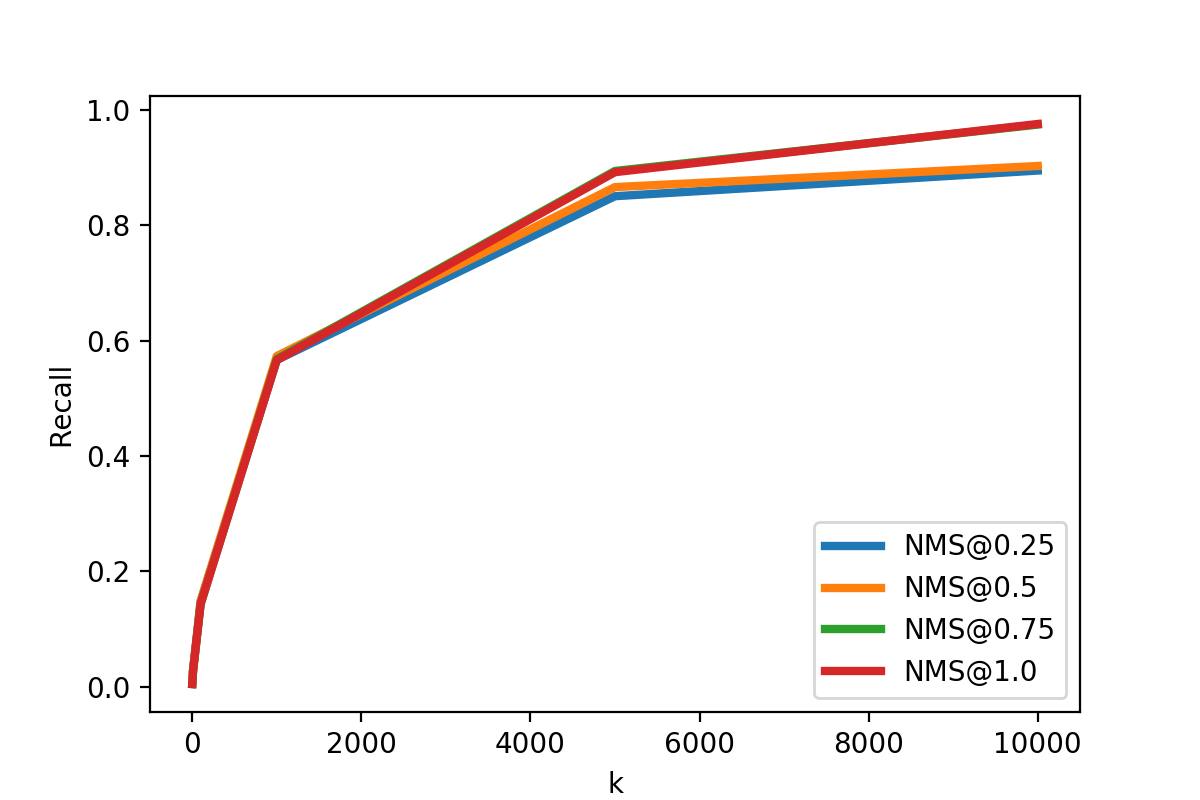

,nms_threshold,R1,R5,R10,R100,R1000,R5000,R10000
9,0.25,0.0045,0.0139,0.0273,0.1476,0.5663,0.8502,0.8947
22,0.50,0.0045,0.0139,0.0273,0.1486,0.5730,0.8660,0.9026
23,0.75,0.0045,0.0141,0.0275,0.1433,0.5677,0.8940,0.9744
8,1.00,0.0045,0.0141,0.0275,0.1431,0.5660,0.8919,0.9754


In [5]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline
%matplotlib notebook

files = glob.glob('data/interim/mcn_retrieval_results/*.csv')
df = pd.concat([pd.read_csv(i) for i in files], axis=0, ignore_index=True, copy=False)
idx = ((df.loc[:, 'loss'] == 'intra+inter') &
       (df.loc[:, 'subset'] == 'val') &
       (df.loc[:, 'cue'] == 'flow'))
k = [1, 5, 10, 100, 1000, 5000, 10000] # get_k_value(df)
kcol = [f'R{i}' for i in k]
nms_value = np.sort(df.loc[idx, 'nms_threshold'])
plt.figure(figsize=(6, 4))
for i in nms_value:
    idx_i = idx & (df.loc[:, 'nms_threshold'] == i)
    r_i = np.array(df.loc[idx_i, kcol]).reshape((-1))
    plt.plot(k, r_i, label=f'NMS@{i}', lw=3)
plt.xlabel('k')
plt.ylabel('Recall')
plt.legend(loc='best')
df.loc[idx, ['nms_threshold'] + kcol].sort_values(by='nms_threshold', ascending=True)

The behavior depends on the type of loss function. In particular, inter videos.

<IPython.core.display.Javascript object>


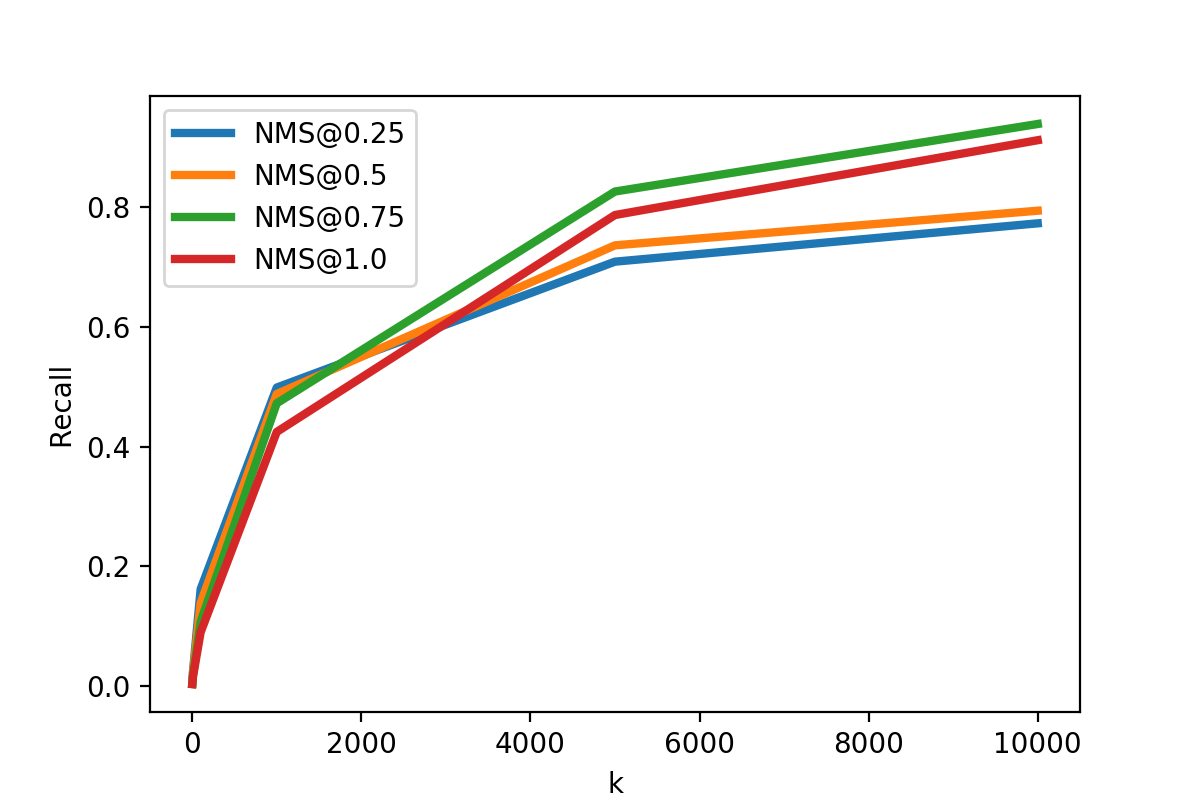

,nms_threshold,R1,R5,R10,R100,R1000,R5000,R10000
29,0.25,0.0031,0.0139,0.0249,0.1617,0.4988,0.7093,0.7734
31,0.50,0.0031,0.0129,0.0225,0.1385,0.4880,0.7366,0.7945
24,0.75,0.0031,0.0103,0.0177,0.1072,0.4725,0.8266,0.9395
19,1.00,0.0031,0.0086,0.0158,0.0897,0.4246,0.7873,0.9124


In [8]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline
%matplotlib notebook

files = glob.glob('data/interim/mcn_retrieval_results/*.csv')
df = pd.concat([pd.read_csv(i) for i in files], axis=0, ignore_index=True, copy=False)
idx = ((df.loc[:, 'loss'] == 'inter') &
       (df.loc[:, 'subset'] == 'val') &
       (df.loc[:, 'cue'] == 'rgb'))
k = [1, 5, 10, 100, 1000, 5000, 10000] # get_k_value(df)
kcol = [f'R{i}' for i in k]
nms_value = np.sort(df.loc[idx, 'nms_threshold'])
plt.figure(figsize=(6, 4))
for i in nms_value:
    idx_i = idx & (df.loc[:, 'nms_threshold'] == i)
    r_i = np.array(df.loc[idx_i, kcol]).reshape((-1))
    plt.plot(k, r_i, label=f'NMS@{i}', lw=3)
plt.xlabel('k')
plt.ylabel('Recall')
plt.legend(loc='best')
df.loc[idx, ['nms_threshold'] + kcol].sort_values(by='nms_threshold', ascending=True)

Effect of loss function

Flow model

<IPython.core.display.Javascript object>


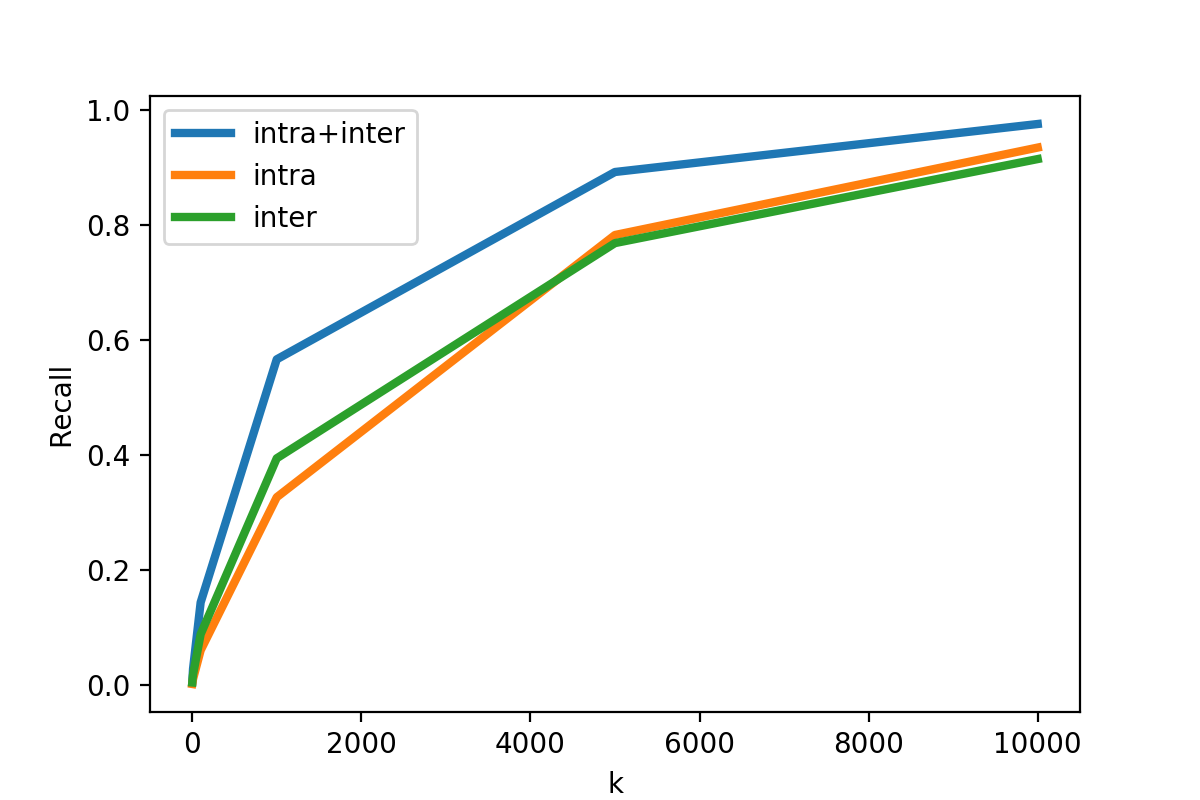

,loss,R1,R5,R10,R100,R1000,R5000,R10000
8,intra+inter,0.0045,0.0141,0.0275,0.1431,0.5660,0.8919,0.9754
16,intra,0.0012,0.0048,0.0096,0.0598,0.3261,0.7823,0.9344
18,inter,0.0038,0.0108,0.0175,0.0878,0.3938,0.7682,0.9144


In [4]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
%matplotlib notebook

files = glob.glob('data/interim/mcn_retrieval_results/*.csv')
df = pd.concat([pd.read_csv(i) for i in files], axis=0, ignore_index=True, copy=False)
idx = ((df.loc[:, 'nms_threshold'] == 1.0) &
       (df.loc[:, 'subset'] == 'val') &
       (df.loc[:, 'cue'] == 'flow'))
var_interest = 'loss'
k = [1, 5, 10, 100, 1000, 5000, 10000] # get_k_value(df)
kcol = [f'R{i}' for i in k]
values_interest = df.loc[idx, var_interest]
plt.figure(figsize=(6, 4))
for i in values_interest:
    idx_i = idx & (df.loc[:, var_interest] == i)
    r_i = np.array(df.loc[idx_i, kcol]).reshape((-1))
    plt.plot(k, r_i, label=f'{i}', lw=3)
plt.xlabel('k')
plt.ylabel('Recall')
plt.legend(loc='best')
df.loc[idx, [var_interest] + kcol]

RGB model

<IPython.core.display.Javascript object>


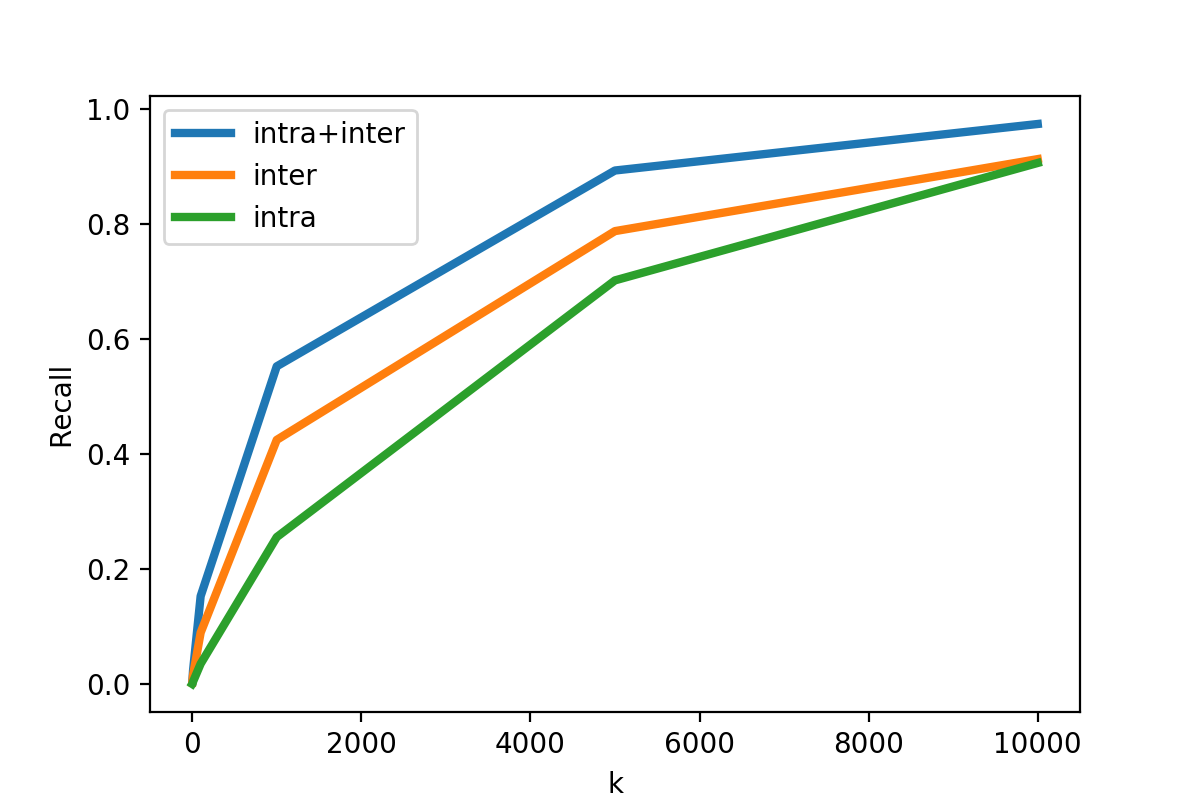

,loss,R1,R5,R10,R100,R1000,R5000,R10000
13,intra+inter,0.0041,0.0120,0.0237,0.1531,0.5524,0.8926,0.9734
19,inter,0.0031,0.0086,0.0158,0.0897,0.4246,0.7873,0.9124
40,intra,0.0005,0.0014,0.0045,0.0356,0.2557,0.7017,0.9057


In [13]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
%matplotlib notebook

files = glob.glob('data/interim/mcn_retrieval_results/*.csv')
df = pd.concat([pd.read_csv(i) for i in files], axis=0, ignore_index=True, copy=False)
idx = ((df.loc[:, 'nms_threshold'] == 1.0) &
       (df.loc[:, 'subset'] == 'val') &
       (df.loc[:, 'cue'] == 'rgb'))
var_interest = 'loss'
k = [1, 5, 10, 100, 1000, 5000, 10000] # get_k_value(df)
kcol = [f'R{i}' for i in k]
values_interest = df.loc[idx, var_interest]
plt.figure(figsize=(6, 4))
for i in values_interest:
    idx_i = idx & (df.loc[:, var_interest] == i)
    r_i = np.array(df.loc[idx_i, kcol]).reshape((-1))
    plt.plot(k, r_i, label=f'{i}', lw=3)
plt.xlabel('k')
plt.ylabel('Recall')
plt.legend(loc='best')
df.loc[idx, [var_interest] + kcol]

Impact of visual cues

<IPython.core.display.Javascript object>


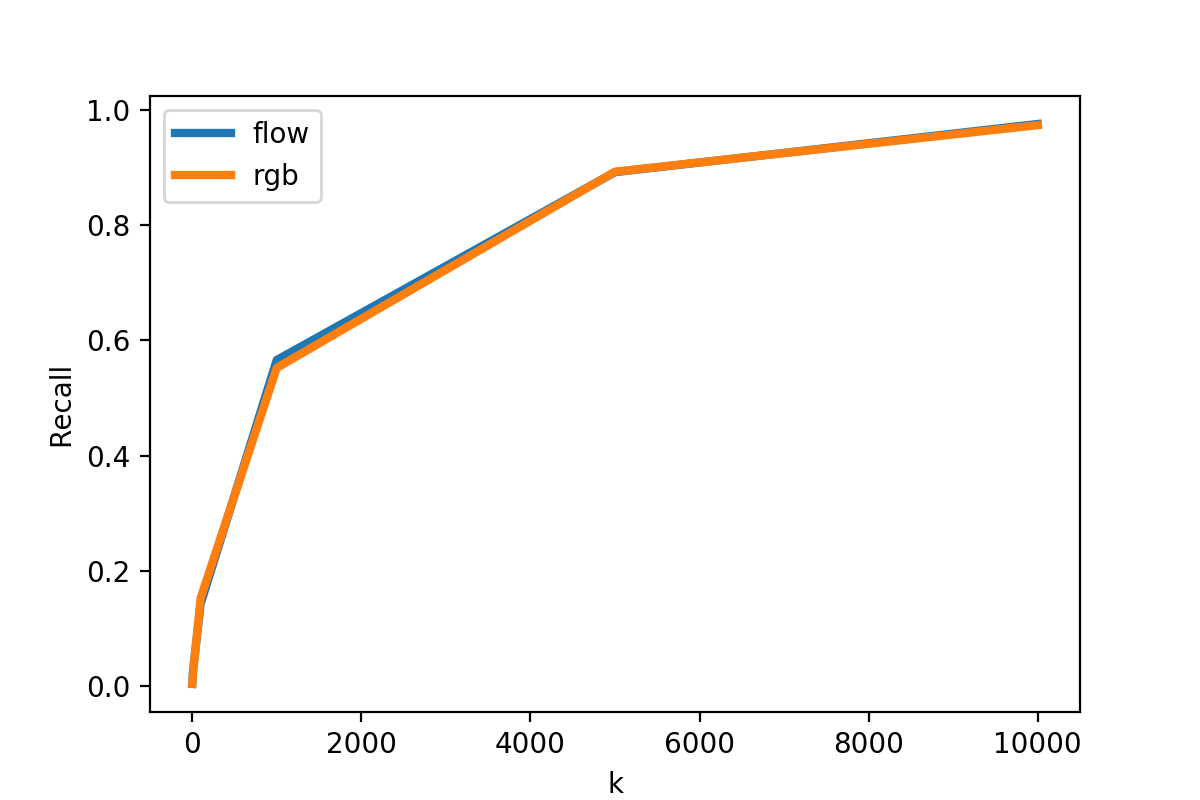

,cue,R1,R5,R10,R100,R1000,R5000,R10000
8,flow,0.0045,0.0141,0.0275,0.1431,0.5660,0.8919,0.9754
13,rgb,0.0041,0.0120,0.0237,0.1531,0.5524,0.8926,0.9734


In [3]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
%matplotlib notebook

files = glob.glob('data/interim/mcn_retrieval_results/*.csv')
df = pd.concat([pd.read_csv(i) for i in files], axis=0, ignore_index=True, copy=False)
idx = ((df.loc[:, 'nms_threshold'] == 1.0) &
       (df.loc[:, 'subset'] == 'val') &
       (df.loc[:, 'loss'] == 'intra+inter'))
var_interest = 'cue'
k = [1, 5, 10, 100, 1000, 5000, 10000] # get_k_value(df)
kcol = [f'R{i}' for i in k]
values_interest = df.loc[idx, var_interest].values
values_interest = np.sort(values_interest)
plt.figure(figsize=(6, 4))
for i in values_interest:
    idx_i = idx & (df.loc[:, var_interest] == i)
    r_i = np.array(df.loc[idx_i, kcol]).reshape((-1))
    plt.plot(k, r_i, label=f'{i}', lw=3)
plt.xlabel('k')
plt.ylabel('Recall')
plt.legend(loc='best')
df.loc[idx, [var_interest] + kcol]

<IPython.core.display.Javascript object>


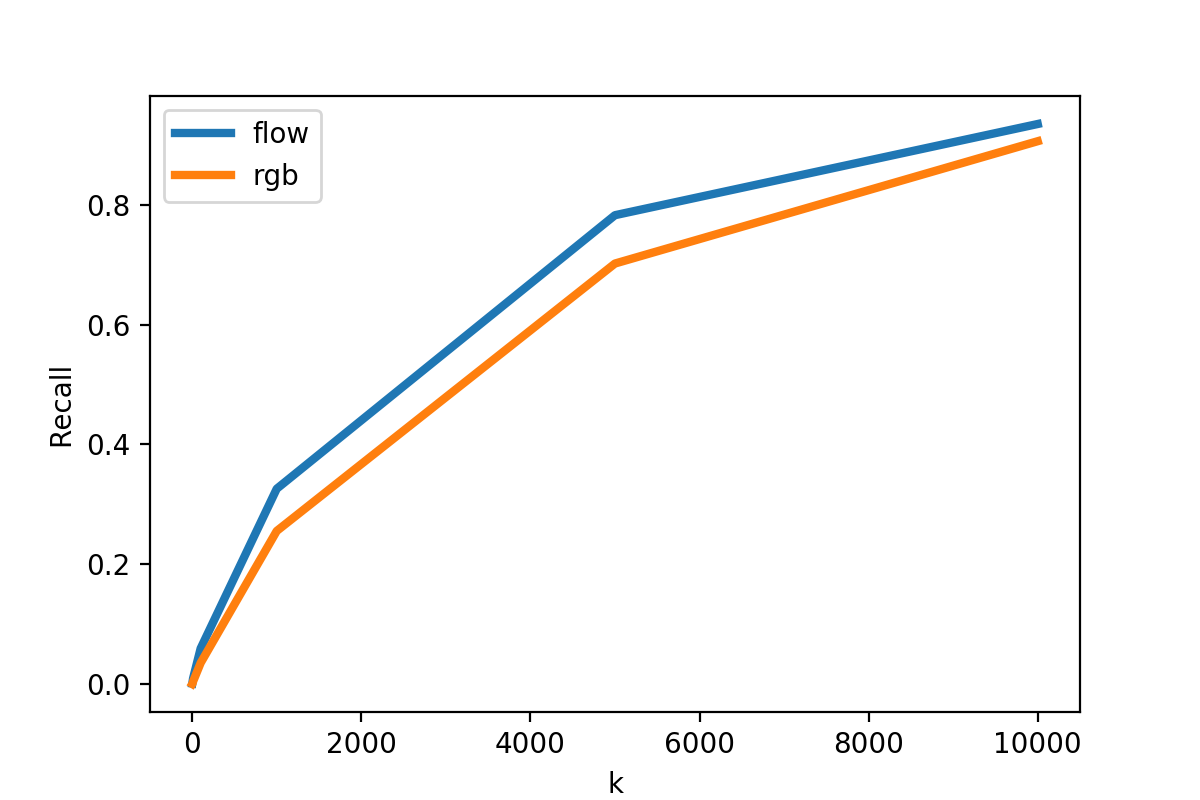

,cue,R1,R5,R10,R100,R1000,R5000,R10000
16,flow,0.0012,0.0048,0.0096,0.0598,0.3261,0.7823,0.9344
40,rgb,0.0005,0.0014,0.0045,0.0356,0.2557,0.7017,0.9057


In [6]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

files = glob.glob('data/interim/mcn_retrieval_results/*.csv')
df = pd.concat([pd.read_csv(i) for i in files], axis=0, ignore_index=True, copy=False)
idx = ((df.loc[:, 'nms_threshold'] == 1.0) &
       (df.loc[:, 'subset'] == 'val') &
       (df.loc[:, 'loss'] == 'intra'))
var_interest = 'cue'
k = [1, 5, 10, 100, 1000, 5000, 10000] # get_k_value(df)
kcol = [f'R{i}' for i in k]
values_interest = df.loc[idx, var_interest].values
values_interest = np.sort(values_interest)
plt.figure(figsize=(6, 4))
for i in values_interest:
    idx_i = idx & (df.loc[:, var_interest] == i)
    r_i = np.array(df.loc[idx_i, kcol]).reshape((-1))
    plt.plot(k, r_i, label=f'{i}', lw=3)
plt.xlabel('k')
plt.ylabel('Recall')
plt.legend(loc='best')
df.loc[idx, [var_interest] + kcol]

## Create GIF for dashboard

~~- Check tar file: only flow files~~

1. Dump video list.

    check notebook `1-inspect_videos.ipynb` section 1.2.d or 1.2.a-b
    
2. Make single GIF
    
    Take a look a `make_gif.py`

    ~~TODO: Joblib for training~~
    
    _Note_: upload videos to youtube or S3 for AMT
    
## Data for dashboard backend

In [3]:
import json
import h5py
import numpy as np
from corpus import Corpus
from dataset import Queries

subset = 'val'
model = 'mcn'
prefix = 'mcn'
extra = 'intra+inter_'

rgb_corpus = f'data/interim/{model}/corpus_{subset}_rgb.hdf5'
flow_corpus = f'data/interim/{model}/corpus_{subset}_flow.hdf5'
rgb_queries = f'data/interim/{model}/queries_{subset}_rgb.hdf5'
flow_queries = f'data/interim/{model}/queries_{subset}_flow.hdf5'
annotations = f'data/raw/{subset}_data_wwa.json'
filename = f'{prefix}_{subset}_{extra}rgb+flow.json'

rgb_corpus = Corpus(rgb_corpus)
flow_corpus = Corpus(flow_corpus, videos=rgb_corpus.videos)
segments = list(map(tuple, rgb_corpus.segments.tolist()))
gt_queries = Queries(
    annotations, rgb_corpus.videos.tolist(), segments)
TOPK = 20
ALPHA = 0.5
UNIQUE_VIDEOS_AT_K = 15
# TODO: add NMS

retrieval_results = {}
segment_list = []
nms_samples = []

num_unique_videos = []
video_retrieved = []
with h5py.File(rgb_queries, 'r') as frgb, h5py.File(flow_queries, 'r') as fflow:
    for sample_key, h5ds in frgb.items():
        query_id = int(sample_key)
        query_rgb = h5ds[:]
        query_flow = fflow[sample_key][:]
        
        rgb_distance = rgb_corpus.search(query_rgb)
        flow_distance = flow_corpus.search(query_flow)
        distance = ALPHA * rgb_distance + (1 - ALPHA) * flow_distance
        # Manual indexing
        distance_sorted_indices = np.argsort(distance)
        distance_sorted = distance[distance_sorted_indices]
        results = rgb_corpus.ind_to_repo(distance_sorted_indices)
        results = results + (distance_sorted,)
        # TODO: add NMS
        # Keep topk (visualization purpose)
        video_indices, segment_indices = results[:2]
        topk_video_indices = video_indices[:TOPK]
        topk_segment_indices = segment_indices[:TOPK]
        topk_score = results[2][:TOPK]
        # ground truth information
        query = gt_queries[query_id]['description']
        gt_video_index = gt_queries[query_id]['video_index']
        gt_segment_indices = gt_queries[query_id]['segment_indices']
        # Label predictions as TP/FP
        tp_fp_videos = video_indices == gt_video_index
        tp_fp_segments = np.in1d(segment_indices, gt_segment_indices)
        tp_fp_labels = np.logical_and(tp_fp_videos, tp_fp_segments)
        topk_tp_fp_labels = tp_fp_labels[:TOPK]
        query_rank = np.where(tp_fp_labels)[0].min()
        video_rank = np.where(tp_fp_videos)[0].min()
        
        # Categorize results
        unique_videos = np.unique(topk_video_indices)
        if len(unique_videos) < UNIQUE_VIDEOS_AT_K:
            nms_samples.append(query_id)
            
        num_unique_videos.append(len(unique_videos))
        video_retrieved.append(np.any(topk_tp_fp_labels))
        
        retrieval_results[query_id] = {
            'query': query,
            'topk_video_indices': topk_video_indices.tolist(),
            'topk_segment_indices': topk_segment_indices.tolist(),
            'topk_scores': topk_score.tolist(),
            'groundtruth_video_index': gt_video_index,
            'groundtruth_segment_indices': gt_segment_indices.tolist(),
            'tp_fp_labels': topk_tp_fp_labels.tolist(),
            # info about query
            # rank's are 1-indexed in backend, thus we add 1
            'rank': int(query_rank) + 1,
            'video_rank': int(video_rank) + 1,
            'unique_videos_at_k': len(unique_videos),
        }
video_list = rgb_corpus.videos.tolist()

with open(filename, 'w') as f:
    json.dump({'results': retrieval_results,
               'videos': video_list,
               'segments': segments},
              f)

# Dump samples to check
import random
for subset, queries in [(f'NMS_{subset}.txt', nms_samples)]:
    with open(subset, 'w') as f:
        for i in queries:
            f.write('{}\n'.format(i))
    print(subset)
    random.shuffle(queries)
    for i in queries[:10]:
        print(gt_queries[i]['description'])
    print()
    
print('Pctg video retrieved', sum(video_retrieved) / len(video_retrieved))
print('Median number of unique videos', np.median(num_unique_videos))

NMS_test.txt
a baby eats a spoon filled with food
both dogs get on a pillow located on the floor.
Man is playing drums and video pans to guy playing guitar.
the dj is proud of the music he's playing.
Two people playing horn instruments are walking in a parade
a person near a lake.
water is completely in view on beach
a man in a blue shirt opens up the top part of an antique typewriter.
A man wearing a maroon colored vest is shown singing and raising his hands as he sings
Eagle flying over the lake

Pctg video retrieved 0.06242228301417558
Median number of unique videos 17.0


In [18]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [19]:
y = np.bincount(num_unique_videos)
plt.bar(range(1, 11), y[1:] / len(num_unique_videos))
plt.ylabel('Pctg')
_ = plt.xlabel('Number of uniques videos at k=10')

NameError: name 'num_unique_videos' is not defined

## Trends

Predict rank based on sentence length

<IPython.core.display.Javascript object>


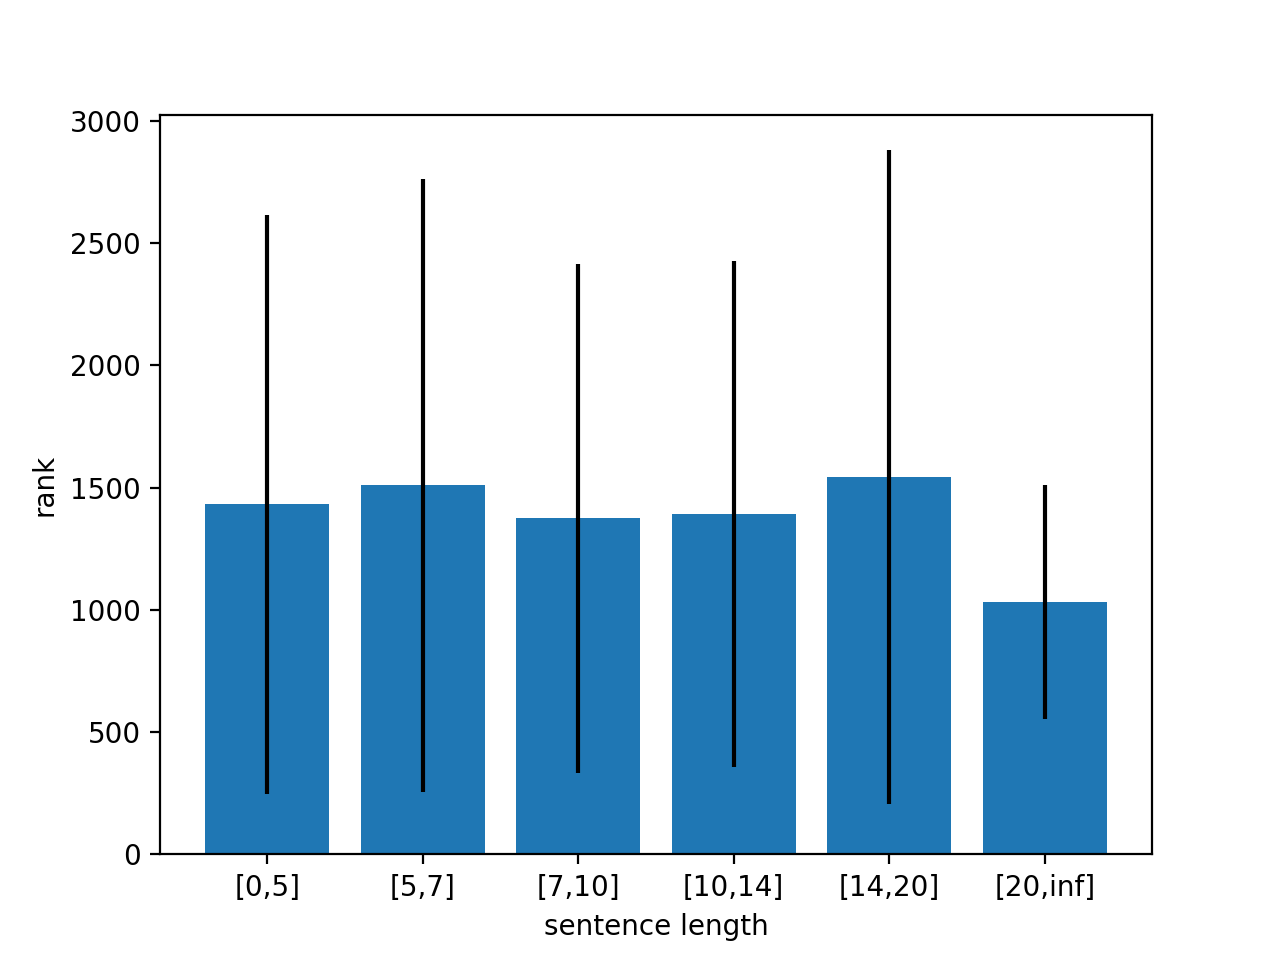

Text(0,0.5,'rank')

In [17]:
import json
import numpy as np
import matplotlib.pyplot as plt
from didemo import sentences_to_words
%matplotlib notebook

filename = '../mr-dashboard/db/mcn_val_intra+inter_rgb+flow.json'
with open(filename, 'r') as f:
    data = json.load(f)

sentence_length = []
rank = []
for k, v in data['results'].items():
    sentence_length.append(len(sentences_to_words([v['query']])))
    rank.append(v['rank'])
sentence_length = np.array(sentence_length)
rank = np.array(rank)

length_range = np.array([0, 5, 7, 10, 14, 20, 45])
avg_rank_range = []
std_rank_range = []
for i, min_l in enumerate(length_range[:-1]):
    max_l = length_range[i + 1]
    idx = np.logical_and(sentence_length >= min_l,
                         sentence_length < max_l)
    # assert idx.sum() > 0
    avg_rank_range.append(rank[idx].mean())
    std_rank_range.append(rank[idx].std())
# plt.scatter(rank, sentence_length)
#plt.hist(sentence_length, length_range)

std_rank_range = np.array(std_rank_range)
index = np.arange(len(length_range) - 1)
bar_width = 0.8
rects2 = plt.bar(
    index, avg_rank_range, bar_width,
    yerr=std_rank_range/2)
xticks_labels = [f'[{v},{length_range[i+1]}]'
                 for i, v in enumerate(length_range[:-1])]
xticks_labels[-1] = f'[{length_range[-2]},inf]'
plt.xticks(index, xticks_labels)
plt.xlabel('sentence length')
plt.ylabel('rank')

<IPython.core.display.Javascript object>


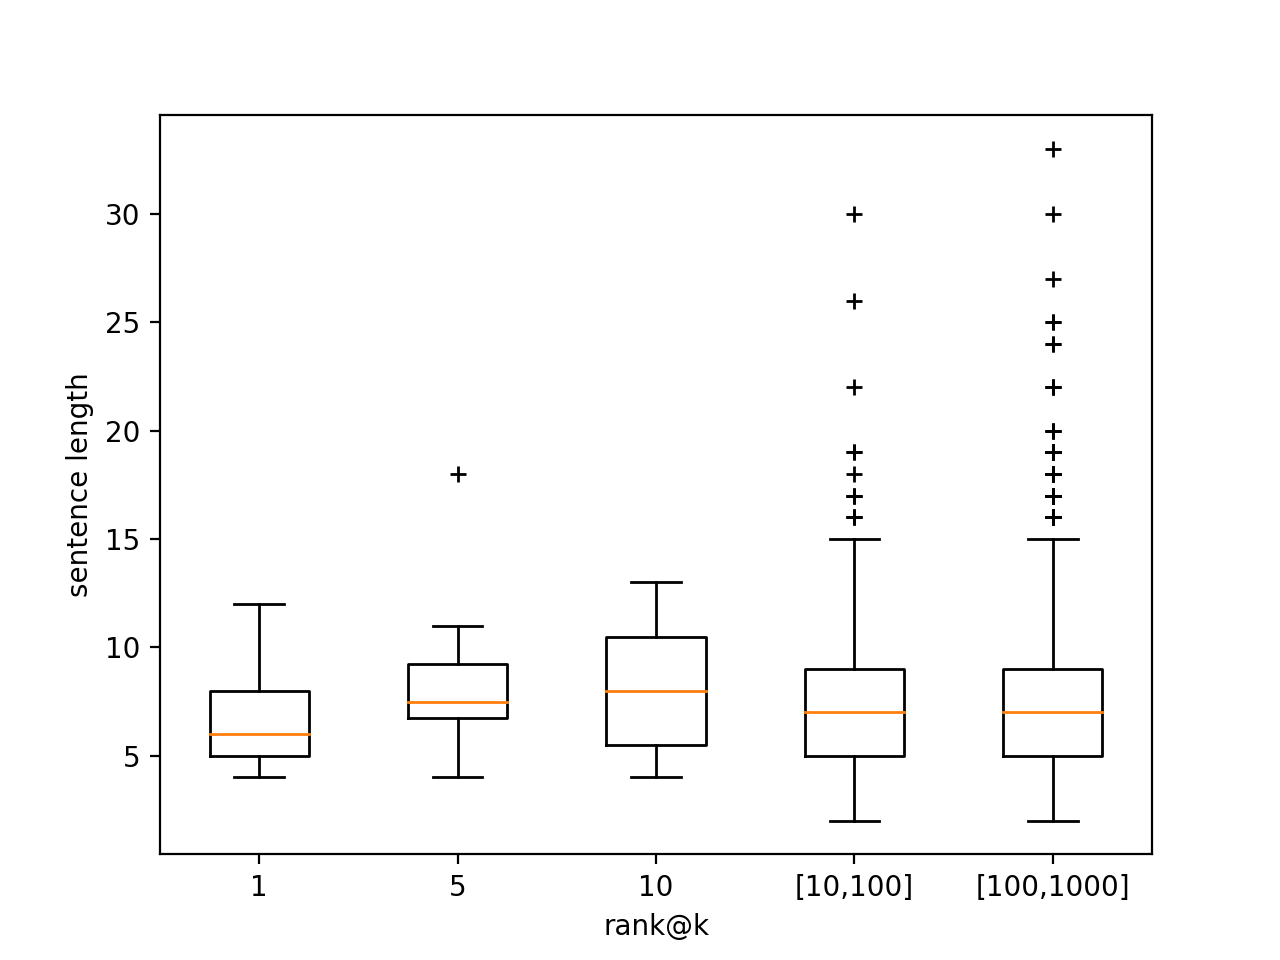

Text(0,0.5,'sentence length')

In [22]:
import json
import numpy as np
import matplotlib.pyplot as plt
from didemo import sentences_to_words
%matplotlib notebook

filename = '../mr-dashboard/db/mcn_val_intra+inter_rgb+flow.json'
with open(filename, 'r') as f:
    data = json.load(f)

sentence_length = []
rank = []
for k, v in data['results'].items():
    sentence_length.append(len(sentences_to_words([v['query']])))
    rank.append(v['rank'])
sentence_length = np.array(sentence_length)
rank = np.array(rank)

rank_samples = [1, 5, 10]
lengths_at_k = []
for ri in rank_samples:
    idx = rank == ri
    lengths_at_k.append(sentence_length[idx])

x = [10, 100, 1000]
for i, v in enumerate(x[:-1]):
    idx = np.logical_and(rank > v, rank <= x[i+1])
    lengths_at_k.append(sentence_length[idx])
    rank_samples.append(f'[{v},{x[i+1]}]')

bp = plt.boxplot(lengths_at_k, notch=0, sym='+', vert=1, whis=1.5)
plt.xticks(np.arange(1, len(rank_samples) + 1), rank_samples)
plt.xlabel('rank@k')
plt.ylabel('sentence length')

<IPython.core.display.Javascript object>


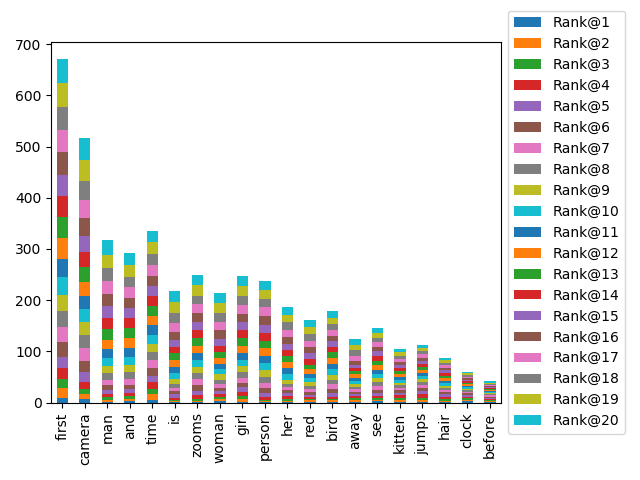

In [2]:
import json
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from didemo import sentences_to_words
from collections import Counter
%matplotlib notebook

filename = '../mr-dashboard/db/mcn_val_intra+inter_rgb+flow.json'
with open(filename, 'r') as f:
    data = json.load(f)
stop_words = ['the', 'a', 'an', 'in', 'on', 'to', 'of', 'up', 'from', 'for']
    
for _, v in data['results'].items():
    words_v = sentences_to_words([v['query']])
    words_v_clean = [i for i in words_v if i not in stop_words]
    data['results'][_]['wc'] = Counter(words_v_clean)

wc_at_k = [None for i in range(20)]
for _, v in data['results'].items():
    k = v['rank'] - 1
    wc_v = v['wc']
    if k > 19:
        continue
    if wc_at_k[k] is None:
        wc_at_k[k] = copy.deepcopy(wc_v)
    else:
        wc_at_k[k].update(wc_v)
        
wc_at_k_cum = [copy.deepcopy(i) for i in wc_at_k]
for i, v in enumerate(wc_at_k_cum[1:]):
    v.update(wc_at_k_cum[i])

num_mc = 10
vocab = set()
for i in wc_at_k_cum:
    for j in i.most_common(num_mc):
        vocab.add(j[0])

vocab = list(vocab)
result = {}
for i, v in enumerate(wc_at_k_cum):
    result[f'Rank@{i + 1}'] = [[] for j in range(len(vocab))]
    for j, vv in enumerate(vocab):
        result[f'Rank@{i + 1}'][j] = 0
        if vv in v:
            result[f'Rank@{i + 1}'][j] = v[vv]
df = pd.DataFrame(result)
df.rename({i: v for i, v in enumerate(vocab)},
          axis=0, inplace=True)
df2 = df.sort_values(by='Rank@20', ascending=False)

f = plt.figure()
df2.plot.bar(stacked=True, ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()
plt.tight_layout()

$\text{HIT}(p^i) :=$ binary variable denoting relevance of a prediction $p^i$ in the $i$-th video for a given query.
    
$a_m^j :=$ annotation associated with the query in the $j$-th video.

# Metric generalization

$\text{HIT}(p^i) = f_{\mathcal{A}} ( \text{tIOU}(p^i, a_m^j) \ge \delta)$

- $\mathcal{A} = \{ a_m^j \}$ represent the set of annotations of a given query

- How to define $f_{\mathcal{A}}$? Is it out of the scope of the project?

# Old notes

Note: This is not related to the tIOU threshold. Only a single, golden, annotation would circumvent this problem.

Concensus - thresholding strategies:
- max. Assigns a true if the prediction match any annotation.
Makes problem easier as the chance increases proportionally to ambiguity of query. It's sensitive to outliers in annotation process. Probably relevant for tIOU.

~~Among the thresholding strategies, we have:~~

~~- average. Makes problem harder as it forces to agree with multiple annotators. It's also sensitive to outliers.~~

~~- average over a subset of annotations. As above but accounting for outliers.~~

~~Thresholding implies to compute a given metric a measure the~~
~~For consistency with DiDeMo standard, we opt for thresholding:~~

Implementation note: given multiple annotations for each query is not conveninent to deal with the raw indexes from the feature matrix. Moreover, those indexes would be useless for considering tIOU. Hopefully, we have a function to invert those indexes into video and segment indexes. However, we need to keep consistency in the list of videos and segments to make an apple 2 apple comparsion.

Evaluation pseudo-code

```
inputs: list of queries; ground-truth, k

recall_at_k = []
miou = []
for each query:
    get vector
    compute distance and return sorted list of indexes
    # prediction would end here
    # code for server could continue to provide more info.
    # like red to miss and green for hit ;)
    
    # evaluation
    for i in range(k)
        if video_idx[i] == gt[query][video_idx]:
            check if it's the segment we are looking for
            miou.append()
        else:
            miou.append(0)

sum(recall_at_k) / len(recall_at_k)
sum(miou_at_k) / len(miou_at_k)
```

DiDeMo evaluation

```python
average_ranks = []
average_iou = []
for s, d in zip(segments, data):
  pred = s[0]
  ious = [iou(pred, t) for t in d['times']]
  average_iou.append(np.mean(np.sort(ious)[-3:]))
  ranks = [rank(s, t) for t in d['times']]
  average_ranks.append(np.mean(np.sort(ranks)[:3]))
rank1 = np.sum(np.array(average_ranks) <= 1)/float(len(average_ranks))
rank5 = np.sum(np.array(average_ranks) <= 5)/float(len(average_ranks))
miou = np.mean(average_iou)
```